In [1]:
pip install torch torchvision matplotlib


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Epoch 0/50] [Batch 0/13] [D loss: 0.6936] [G loss: 0.7033]
[Epoch 0/50] [Batch 1/13] [D loss: 0.6934] [G loss: 0.7024]
[Epoch 0/50] [Batch 2/13] [D loss: 0.6930] [G loss: 0.7020]
[Epoch 0/50] [Batch 3/13] [D loss: 0.6923] [G loss: 0.7010]
[Epoch 0/50] [Batch 4/13] [D loss: 0.6928] [G loss: 0.7001]
[Epoch 0/50] [Batch 5/13] [D loss: 0.6931] [G loss: 0.6996]
[Epoch 0/50] [Batch 6/13] [D loss: 0.6931] [G loss: 0.6987]
[Epoch 0/50] [Batch 7/13] [D loss: 0.6920] [G loss: 0.6982]
[Epoch 0/50] [Batch 8/13] [D loss: 0.6924] [G loss: 0.6975]
[Epoch 0/50] [Batch 9/13] [D loss: 0.6913] [G loss: 0.6974]
[Epoch 0/50] [Batch 10/13] [D loss: 0.6912] [G loss: 0.6968]
[Epoch 0/50] [Batch 11/13] [D loss: 0.6911] [G loss: 0.6963]
[Epoch 0/50] [Batch 12/13] [D loss: 0.6904] [G loss: 0.6952]
[Epoch 1/50] [Batch 0/13] [D loss: 0.6904] [G loss: 0.6952]
[Epoch 1/50] [Batch 1/13] [D

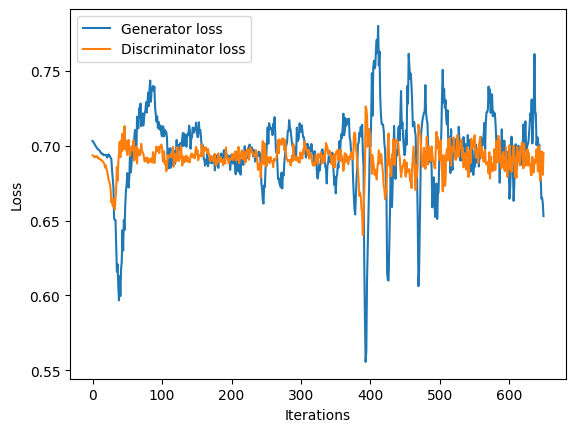

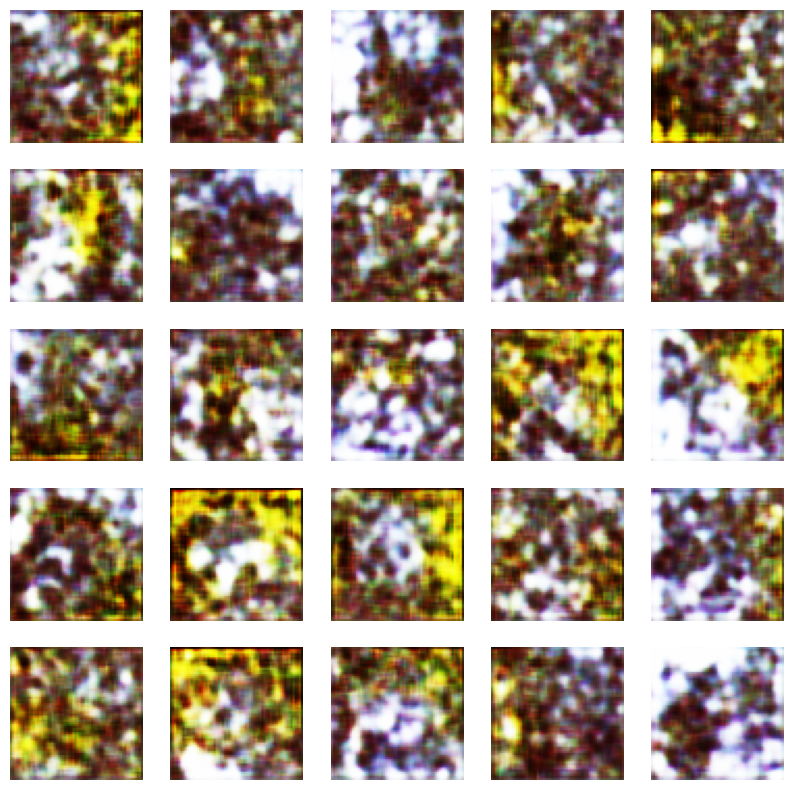

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from PIL import Image
import os

# Generator model
class Generator(nn.Module):
    def __init__(self, latent_dim=100, img_channels=3, img_size=64):
        super(Generator, self).__init__()
        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, img_channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

# Discriminator model
class Discriminator(nn.Module):
    def __init__(self, img_channels=3, img_size=64):
        super(Discriminator, self).__init__()
        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(img_channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        ds_size = img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        return validity

# Function to check if a file is a valid image
def is_image_file(filename):
    try:
        with Image.open(filename) as img:
            return True
    except:
        return False

# Dataset class
class CatDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images = [f for f in os.listdir(data_dir) if is_image_file(os.path.join(data_dir, f))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.images[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# Hyperparameters
latent_dim = 100
batch_size = 64
learning_rate = 0.0002
num_epochs = 50
img_size = 64
img_channels = 3

# Data preprocessing
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * img_channels, [0.5] * img_channels),
])

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset
data_dir = '/content/drive/MyDrive/CAT_03'  # Replace with the correct path
dataset = CatDataset(data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize models and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = Generator(latent_dim, img_channels, img_size).to(device)
discriminator = Discriminator(img_channels, img_size).to(device)
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# Loss function
adversarial_loss = nn.BCELoss()

# Training loop
train_loss_G = []
train_loss_D = []

for epoch in range(num_epochs):
    for i, imgs in enumerate(dataloader):
        valid = torch.ones((imgs.size(0), 1), requires_grad=False).to(device)
        fake = torch.zeros((imgs.size(0), 1), requires_grad=False).to(device)

        real_imgs = imgs.to(device)

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn((imgs.size(0), latent_dim)).to(device)
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        train_loss_G.append(g_loss.item())
        train_loss_D.append(d_loss.item())

        print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

# Plot the training losses
plt.plot(train_loss_G, label='Generator loss')
plt.plot(train_loss_D, label='Discriminator loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Generate and display some images
z = torch.randn(25, latent_dim).to(device)
gen_imgs = generator(z)
gen_imgs = gen_imgs.cpu().detach().numpy()

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow((gen_imgs[i].transpose(1, 2, 0) + 1) / 2)
    ax.axis('off')
plt.show()
